# SMCF Test
## SMCF Calculation and MU
## SMCF evaluation for Color Sensors

In [2]:
from scipy import rand

# temp import only
from empir19nrm02.tools.help import strd, label_font_size, plot_cmf2, save_fig, get_target, label_management, \
    quantil, display_responsivity

#%run -i jhelp


import luxpy as lx
import numpy as np
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression

from empir19nrm02.f1prime import py_f1PrimeGlx
from empir19nrm02.tools import plotCorrMatrixSmall
%matplotlib inline
from luxpy import _CMF, plot_spectrum_colors, _CIE_ILLUMINANTS
from luxpy.color.utils import plot_cmfs, plot_color_data
from luxpy.toolboxes.photbiochem import _BLH, Km_correction_factor
from luxpy.toolboxes.photbiochem import _ACTIONSPECTRA_CIES026
from luxpy.toolboxes.indvcmf import add_to_cmf_dict
from luxpy.spectrum import spd_to_xyz

from empir19nrm02 import _SPD, _RES
from empir19nrm02.tools import  plot_2D, plotCorrMatrixSmall
from empir19nrm02.tools.help import display_color_diagram, display_spectra
from empir19nrm02.MC import MCVar, DistributionParam, NameUnit, MCVectorVar, py_getBaseFunctions

print('Version of luxpy:', lx.__version__)
out_dir = 'SMCF_Test'

import os
print( 'CWD:', os.getcwd())

Version of luxpy: v1.10.0
CWD: E:\TTBV\Python\empir19nrm02\empir19nrm02\Jupyter


XDetectors


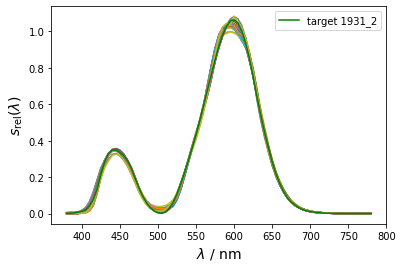

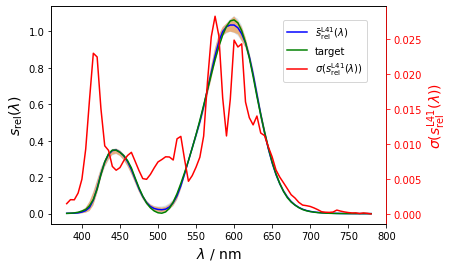

In [3]:
_name = 'XDetectors'
_detectors=_RES[_name]['S']['data'].copy()
XNorm, f1pX = display_responsivity(_name, _detectors, cieobs='1931_2', s_target_index=1, out_dir=out_dir)

YDetectors


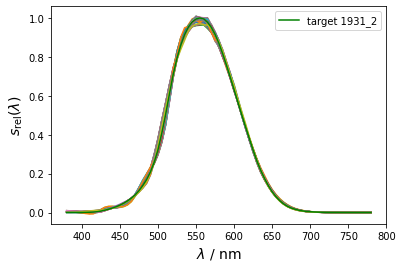

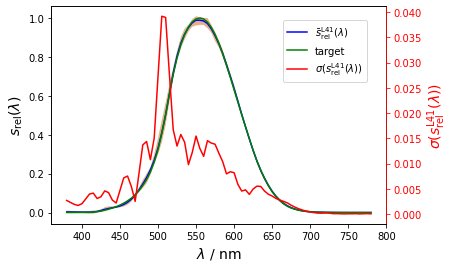

In [4]:
_name = 'YDetectors'
_detectors=_RES[_name]['S']['data'].copy()
YNorm, f1pY = display_responsivity(_name, _detectors, cieobs='1931_2', s_target_index=2, out_dir=out_dir)

ZDetectors


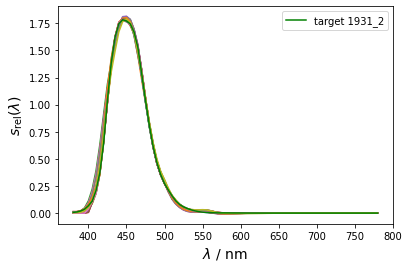

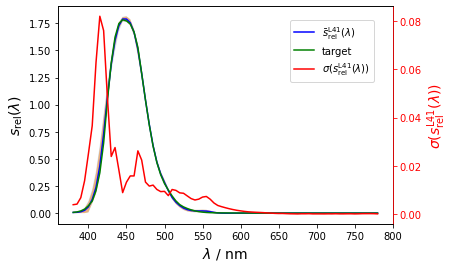

In [5]:
_name = 'ZDetectors'
_detectors=_RES[_name]['S']['data'].copy()
ZNorm, f1pZ = display_responsivity(_name, _detectors, cieobs='1931_2', s_target_index=3, out_dir=out_dir)

In [6]:
detectors_color = np.zeros((3,XNorm.shape[0], XNorm.shape[1]))
detectors_color[0] = XNorm.copy()
detectors_color[1] = YNorm.copy()
detectors_color[2] = ZNorm.copy()


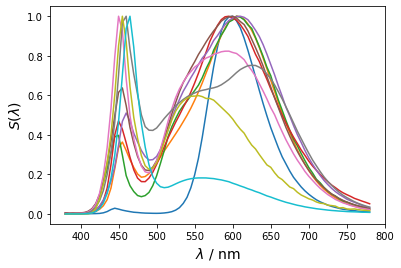

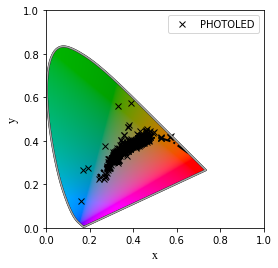

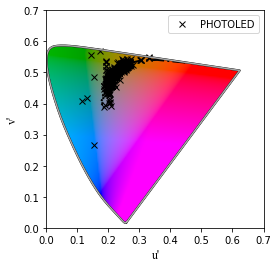

In [7]:
#spd = 'MONOLED'
spd = 'PHOTOLED'

_spectra=lx.cie_interp( _SPD[spd]['S']['data'], wl_new=detectors_color[0,0,:], kind = 'S')

display_spectra( spd, _spectra, curvenumber=10)
save_fig(out_dir, spd + '_spectra')

display_color_diagram(spd, _spectra,cspace='Yxy')
save_fig(out_dir, spd + '_xy')

display_color_diagram(spd, _spectra,cspace='Yuv76')
save_fig(out_dir, spd + '_uv76')

In [8]:
g_S_C_ref = None
g_S_Z_ref = None
g_s_detector_ref = None

def smcf_set_ref( _S_C_ref, _S_Z_ref, _s_detector_ref):
    global g_S_C_ref, g_S_Z_ref, g_s_detector_ref

    if isinstance(_S_C_ref,str):
        g_S_C_ref = _CIE_ILLUMINANTS[_S_C_ref].copy()
    else:
        if isinstance(_S_C_ref, SPD):
            g_S_C_ref = np.vstack( (_S_C_ref.wl, _S_C_ref.value))
        else:
            g_S_C_ref = _S_C_ref.copy()

    if isinstance(_S_Z_ref,str):
        g_S_Z_ref = _CIE_ILLUMINANTS[_S_Z_ref].copy()
    else:
        if isinstance(_S_Z_ref, SPD):
            g_S_Z_ref = np.vstack( (_S_Z_ref.wl, _S_Z_ref.value))
        else:
            g_S_Z_ref = _S_Z_ref.copy()
    if isinstance(_S_Z_ref, SPD):
        g_s_detector_ref = np.vstack( (_s_detector_ref.wl, _s_detector_ref.value))
    else:
        g_s_detector_ref = _s_detector_ref.copy()
    return

def smcf_calculation( S_Z, s_detector, S_C='A', cieobs='1931_2', s_target_index=2, interp_kind = 'S', use_ref = False, use_global_ref = False):

    # Get illuminant:
    if isinstance(S_C,str): S_C = _CIE_ILLUMINANTS[S_C].copy()

    s_target = _CMF[cieobs]['bar'][[0,s_target_index]].copy() if isinstance(cieobs, str) else cieobs[[0,s_target_index]].copy()

    wlr = s_detector[0] # get wavelength range from the detector data
    dl = lx.getwld(wlr) # wavelength differences (unequal wavelength spacings are taken into account)
    dl = dl*np.ones_like(wlr) # ensure array like for matrix multiplication

    # Interpolate measured spectrum to desired wavelength range:
    s_target = lx.cie_interp(s_target, wlr, kind = interp_kind)[1:]
    S_C = lx.cie_interp(S_C, wlr, kind = interp_kind)[1:]
    S_Z = lx.cie_interp(S_Z, wlr, kind = interp_kind)[1:]
    s_detector = s_detector[1:]

    # taking the first information as reference
    if use_ref:
        if use_global_ref:
            S_C_ref = lx.cie_interp(g_S_C_ref, wlr, kind = interp_kind)[1:]
            S_Z_ref = lx.cie_interp(g_S_Z_ref, wlr, kind = interp_kind)[1:]
            s_detector_ref = lx.cie_interp(g_s_detector_ref, wlr, kind = interp_kind)[1:]
            S_C_ref = np.tile(S_C_ref[0],(S_C.shape[0],1))
            S_Z_ref = np.tile(S_Z_ref[0],(S_Z.shape[0],1))
            s_detector_ref = np.tile(s_detector_ref[0],(s_detector.shape[0],1))
        else:
            S_C_ref = np.tile(S_C[0],(S_C.shape[0],1))
            S_Z_ref = np.tile(S_Z[0],(S_Z.shape[0],1))
            s_detector_ref = np.tile(s_detector[0],(s_detector.shape[0],1))
    else:
        S_C_ref = S_C
        S_Z_ref = S_Z
        s_detector_ref = s_detector

    use_luxpy = False
    if use_luxpy:
        # Calculate s_rel:
        s_rel = (s_target @ (S_C_ref*dl).T) / (s_detector_ref @ (S_C*dl).T) * s_detector
        # Calculate spectral mismatch correction factors:
        F = (S_Z_ref @ (s_target*dl).T) / (S_Z @ (s_rel*dl).T)
    else:
        # Calculate spectral mismatch correction factors:
        F1 = (S_Z_ref @ (s_target*dl).T) / (S_Z @ (s_detector*dl).T)
        F2 = (S_C_ref @ (s_target*dl).T) / (S_C @ (s_detector_ref*dl).T)
        F = F1/F2

    return F

In [9]:
SMCF_A = np.zeros((3,_spectra.shape[0]-1, detectors_color.shape[1]-1))
SMCF_L41 = np.zeros((3,_spectra.shape[0]-1, detectors_color.shape[1]-1))
for i in range(3):
    #SMCF_A[i]=lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors( _spectra, detectors_color[i], S_C='A', cieobs='1931_2', s_target_index=i+1)
    #SMCF_L41[i]=lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors( _spectra, detectors_color[i], S_C='LED_L41', cieobs='1931_2', s_target_index=i+1)
    SMCF_A[i]=smcf_calculation( _spectra, detectors_color[i], S_C='A', cieobs='1931_2', s_target_index=i+1)
    SMCF_L41[i]=smcf_calculation( _spectra, detectors_color[i], S_C='LED_L41', cieobs='1931_2', s_target_index=i+1)

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def SMCF_plot( _smcfData, calib='A', name='SMCF'):
    fig, ax1 = pyplot.subplots(figsize=(7,7))
    im1 = ax1.imshow(_smcfData, aspect='auto',
                    #extent=[wl_scale[0], wl_scale[-1], wl_scale[-1], wl_scale[0]],
                    cmap="jet", interpolation="nearest")
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    ax1.set_title(name)
    ax1.set_xlabel('Detector#', fontsize=label_font_size)
    ax1.set_ylabel('SD#', fontsize=label_font_size)

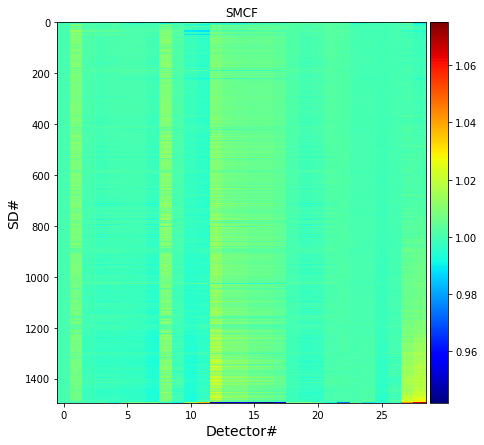

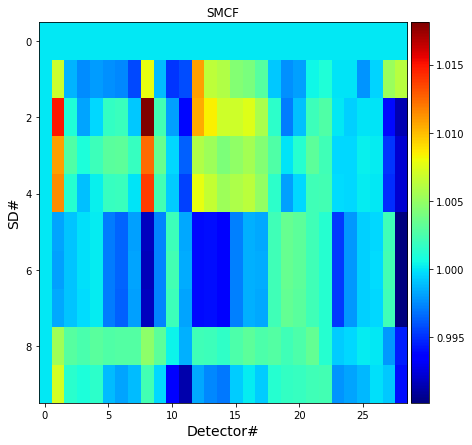

In [11]:
SMCF_plot(SMCF_A[0], calib='A', name='SMCF')
SMCF_plot(SMCF_A[0][0:10, :], calib='A', name='SMCF')
save_fig(out_dir, 'SMCFA_img')

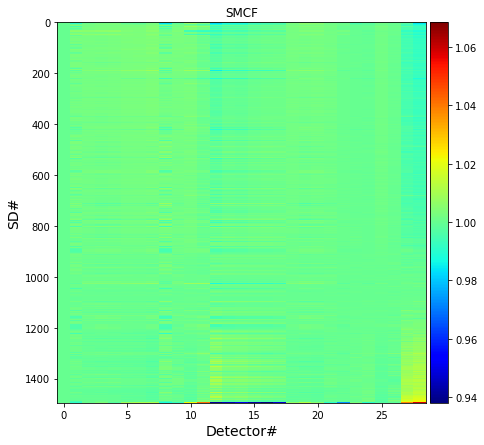

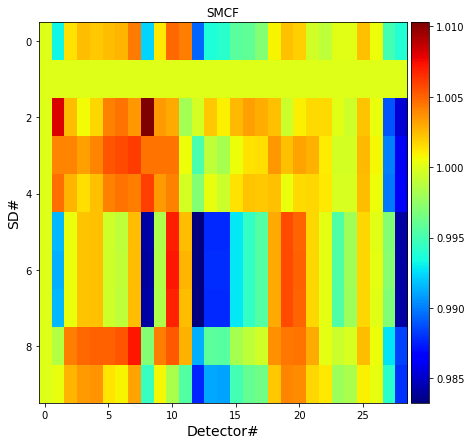

In [12]:
SMCF_plot(SMCF_L41[0], calib='L41', name='SMCF')
SMCF_plot(SMCF_L41[0][0:10, :], calib='L41', name='SMCF')
save_fig(out_dir, 'SMCFL41_img')

In [13]:
channels = detectors_color.shape[0]
# 0 is the wavellength scale, 1 is the ideal detector
detectorItem = 2
# 0 is the wavelenght scale, 1 is StdIllA, 2 is L41
SDItem = 2

if detectorItem == 0 or SDItem == 0:
    print( 'Error # 0 is not a detector or SD. This is the wavelength scale')

#calibSD = 'A'
calibSD = 'LED_L41'
SMCFColor = np.zeros(channels)

for i in range( channels):
    SMCFColor[i]=lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors(
        np.vstack( (_spectra[0], _spectra[SDItem])),
        np.vstack( (detectors_color[i, 0], detectors_color[i, detectorItem])),
        S_C=calibSD, cieobs='1931_2', s_target_index=i+1)

print( SMCFColor)

[1.0000e+00 1.0000e+00 1.0000e+00]


In [14]:
from empir19nrm02.tools import plot_2D
from luxpy import SPD
from empir19nrm02.MC.MCSim import MCVectorVar, NameUnit, DistributionParam, MCSimulation,noise_list_default
from empir19nrm02.tools import sumMC

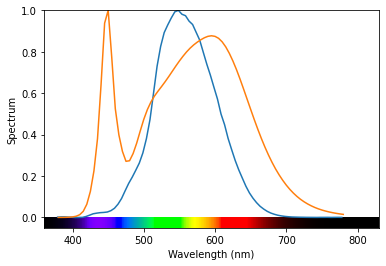

In [15]:
SMCF = MCVar(name=NameUnit('SMCF', '1'))
NumberTrials = 1000
ch = 1
detectorSPD = lx.SPD( spd=np.vstack((detectors_color[ch, 0], detectors_color[ch, detectorItem])/np.max(detectors_color[ch, detectorItem])),ax0iswl=True)
spectrumSPD = lx.SPD( spd=np.vstack((_spectra[0], _spectra[SDItem]/np.max(_spectra[SDItem]))),ax0iswl=True)

detectorSPD.plot()
spectrumSPD.plot()
save_fig(out_dir, 'Sample_Distribution')

## Evaluate the noise sensitivity

In [16]:
from luxpy import _CIE_ILLUMINANTS

def eval_target_noise( detector = None, spectrum = None, str_target = 'target', name = 'name', S_C = 'A', cieobs = '1931_2', s_target_index=2):

    if detector is None:
        detector = np.vstack((_CMF[cieobs]['bar'][0], _CMF[cieobs]['bar'][s_target_index]))
        detector = lx.cie_interp(detector, wl_new=np.arange(380,780+1,5), kind='S')
    if spectrum is None:
        spectrum = np.vstack((_CIE_ILLUMINANTS[S_C][0], _CIE_ILLUMINANTS[S_C][1]))
        spectrum = lx.cie_interp(spectrum, wl_new=np.arange(380,780+1,5), kind='S')
    detector[1] = detector[1] / np.max(detector[1])
    spectrum[1] = spectrum[1] / np.max(spectrum[1])
    _detectorsNoise = detector.copy()
    _spectrumNoise = spectrum.copy()

    for i in range(0, detector.shape[1]):
        to_add = detector.copy()
        to_add[1,i] += .1
        _detectorsNoise= np.vstack((_detectorsNoise, to_add[1]))

        to_add1 = spectrum.copy()
        to_add1[1,i] += .1
        _spectrumNoise= np.vstack((_spectrumNoise, to_add1[1]))

    fig, ax1 = pyplot.subplots()
    ax1.plot(_detectorsNoise[0], _detectorsNoise[1], 'g-', label=str_target)
    ax1.plot(_detectorsNoise[0], _detectorsNoise[4], 'g*', label=str_target +'$ + \Delta$')
    ax1.plot(_spectrumNoise[0], _spectrumNoise[1], 'r-', label=str_target)
    ax1.plot(_spectrumNoise[0], _spectrumNoise[6], 'r*', label=str_target +'$ + \Delta$')
    ax1.set_xlabel(strd['xlambda'], fontsize=label_font_size)
    ax1.set_ylabel('Signal' + strd['AU'], fontsize=label_font_size)
    ax1.set_xlim([380, 500])
    ax1.set_ylim([0, 0.2])
    pyplot.legend()
    save_fig(out_dir, name + 'noiseSingle')

    npSMCFDetector = smcf_calculation(spectrum, _detectorsNoise, S_C = S_C, cieobs = cieobs, s_target_index=s_target_index, use_ref = True).flatten()
    npSMCFSpectrum = smcf_calculation(_spectrumNoise, detector, S_C = S_C, cieobs = cieobs, s_target_index=s_target_index, use_ref = True).flatten()

    print( npSMCFDetector.shape)
    print( npSMCFSpectrum.shape)
    nsubPlot = 2

    xRange = np.arange(375,780+1,5)

    fig, ax1 = pyplot.subplots()
    #ax2 = ax1.twinx()

    ax1.plot(xRange[1::nsubPlot], npSMCFDetector[1::nsubPlot], 'r-', label='SMCF Detector')
    ax1.plot(xRange[1::nsubPlot], npSMCFSpectrum[1::nsubPlot], 'g-', label='SMCF Spectrum')

    ax1.set_xlabel(strd['xlambda'], fontsize=label_font_size)
    ax1.set_ylabel('$F$', fontsize=label_font_size)
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    pyplot.legend(lines, labels, bbox_to_anchor=(0.0, -0.3, 1, 0), loc='lower left',
               ncol=7, mode="expand", borderaxespad=0.)
    save_fig(out_dir, name + 'noiseEval')

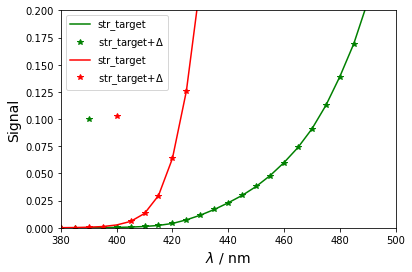

(82,)
(82,)


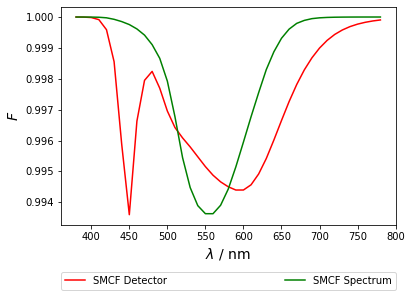

In [17]:
eval_target_noise(detector = None,
                  spectrum = None , str_target='str_target', name='name', S_C = 'L41')

#eval_target_noise( detector = np.vstack( (detectors_color[1, 0], detectors_color[1, 1])),
#                   spectrum = np.vstack( (spectrumSPD.wl, spectrumSPD.value)) , str_target='str_target', name='name', S_C = 'L41')

In [18]:
def eval_target_shift( detector = None, spectrum = None, str_target = 'target', name = 'name', S_C = 'A', cieobs = '1931_2', s_target_index=2):
    shift2min = 0
    shift2max = 5
    shift_steps = 0.1
    shift_range = np.arange(shift2min, shift2max+2*shift_steps, shift_steps)

    if detector is None:
        detector = np.vstack((_CMF[cieobs]['bar'][0], _CMF[cieobs]['bar'][s_target_index]))
        detector = lx.cie_interp(detector, wl_new=np.arange(380,780+1,5), kind='S')
    if spectrum is None:
        spectrum = np.vstack((_CIE_ILLUMINANTS[S_C][0], _CIE_ILLUMINANTS[S_C][1]))
        spectrum = lx.cie_interp(spectrum, wl_new=np.arange(380,780+1,5), kind='S')
    detector[1] = detector[1] / np.max(detector[1])
    spectrum[1] = spectrum[1] / np.max(spectrum[1])

    _detectorsShift = detector.copy()
    _spectrumShift = spectrum.copy()

    for i in shift_range:
        wl_current = _detectors[0]+i
        target_moved = np.vstack((wl_current, detector[1]))
        target_interpolated = lx.cie_interp(target_moved, detector[0], negative_values_allowed=True, kind='linear')
        _detectorsShift = np.vstack((_detectorsShift, target_interpolated[1]))

        target_moved1 = np.vstack((wl_current, spectrum[1]))
        target_interpolated1 = lx.cie_interp(target_moved1, spectrum[0], negative_values_allowed=True, kind='linear')
        _spectrumShift = np.vstack((_spectrumShift, target_interpolated1[1]))

    detectors_shift_number = _detectorsShift.shape[0]
    pyplot.plot(_detectorsShift[0,:], _detectorsShift[2,:], 'r-', label='shift ' + str(shift2min)+ ' nm')
    pyplot.plot(_detectorsShift[0,:], _detectorsShift[int((detectors_shift_number-1)/2),:], 'g-', label=str_target)
    pyplot.plot(_detectorsShift[0,:], _detectorsShift[detectors_shift_number-1,:], 'b-', label='shift +' + str(shift2max)+ ' nm')
    pyplot.xlabel(strd['xlambda'], fontsize=label_font_size)
    pyplot.ylabel(str_target + ',' + strd['srelLambda'], fontsize=label_font_size)
    pyplot.legend()
    save_fig(out_dir, name + 'DetectorShiftsSingle')

    spectrum_shift_number = _spectrumShift.shape[0]
    pyplot.plot(_spectrumShift[0,:], _spectrumShift[2,:], 'r-', label='shift ' + str(shift2min)+ ' nm')
    pyplot.plot(_spectrumShift[0,:], _spectrumShift[int((spectrum_shift_number-1)/2),:], 'g-', label=str_target)
    pyplot.plot(_spectrumShift[0,:], _spectrumShift[spectrum_shift_number-1,:], 'b-', label='shift +' + str(shift2max)+ ' nm')
    pyplot.xlabel(strd['xlambda'], fontsize=label_font_size)
    pyplot.ylabel(str_target + ',' + strd['srelLambda'], fontsize=label_font_size)
    pyplot.legend()
    save_fig(out_dir, name + 'SpectrumShiftsSingle')

    npSMCFDetector = smcf_calculation(spectrum, _detectorsShift, S_C = S_C, cieobs = cieobs, s_target_index=s_target_index, use_ref = True).flatten()
    npSMCFSpectrum = smcf_calculation(_spectrumShift, detector, S_C = S_C, cieobs = cieobs, s_target_index=s_target_index, use_ref = True).flatten()

    print( npSMCFDetector.shape)
    print( npSMCFSpectrum.shape)

    fig, ax1 = pyplot.subplots()
    #ax2 = ax1.twinx()

    xRange = shift_range
    subPlot = 5
    ax1.plot(xRange[1::subPlot], npSMCFDetector[1::subPlot], 'rx', label='Detector')
    ax1.plot(xRange[1::subPlot], npSMCFSpectrum[1::subPlot], 'gx', label='Spectrum')

    ax1.set_xlabel('$\Delta\lambda$ / nm', fontsize=label_font_size)
    ax1.set_ylabel('F / A.U.', fontsize=label_font_size)
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    pyplot.legend(lines, labels, bbox_to_anchor=(0.0, -0.2, 1, 0), loc='upper left',
               ncol=7, mode="expand", borderaxespad=0.)
    save_fig(out_dir, name + 'ShiftsEval')

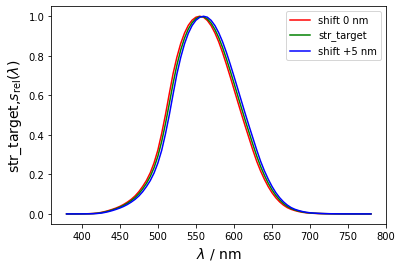

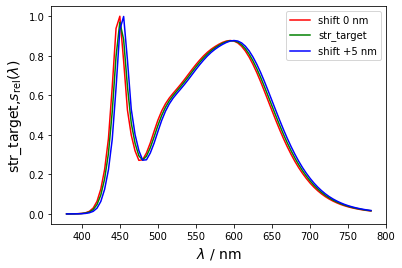

(53,)
(53,)


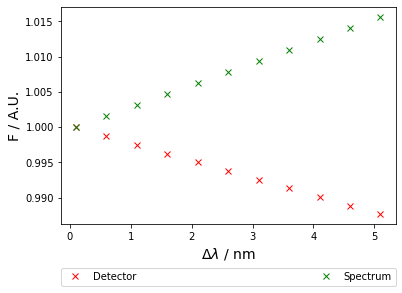

In [19]:
eval_target_shift(detector = None,
                  spectrum = None , str_target='str_target', name='name', S_C = 'L41')

#eval_target_noise( detector = np.vstack( (detectors_color[1, 0], detectors_color[1, 1])),
#                   spectrum = np.vstack( (spectrumSPD.wl, spectrumSPD.value)) , str_target='str_target', name='name', S_C = 'L41')

In [21]:
def runSimpleMC( detectorMC, SMCF, NumberTrials, model_single):
    input = [detectorMC]
    output = [SMCF]

    sim = MCSimulation(trials=NumberTrials)
    sim.set_input_var(input)
    sim.set_output_var(output)
    sim.generate()
    sim.calculate_model( model_single)
    return sim.output_var


petriNumbers = 4
uSMCF = np.zeros(petriNumbers)
mSMCF = np.zeros(petriNumbers)


simulationResult = {}
for key in noise_list_default:
    if 'f_' in key:
        simulationResult[key] =  [ np.zeros(petriNumbers), np.zeros(petriNumbers)]
    else:
        simulationResult[key] =  [0., 0.]


detectorList = list()
wl = _detectors[0] # get wavelength range from the detector data


def model_single(detector):
    # for test only
    global  ch
    # implementation
    detectorList.append( detector)
    spectmp = np.vstack( (spectrumSPD.wl, spectrumSPD.value) )
    detectortmp = np.vstack( (wl, detector) )
    SMCF = smcf_calculation( spectmp, detectortmp, S_C=calibSD, cieobs='1931_2', s_target_index=ch+1, use_ref=True, use_global_ref=True)
#    SMCF = lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors(
#                        spectmp, detectortmp, S_C=calibSD, cieobs='1931_2', s_target_index=ch+1)
    # Vektoren gehen noch nicht als Rückgabe
    return [SMCF]

def plot_dist( key):
    t = np.zeros((len(detectorList)+1, detectorList[0].shape[1]))
    t[0] = detectorList[0].wl
    for i in range(len(detectorList)):
        t[i+1] = detectorList[i].value
    SPD(spd=t).plot()
    save_fig(out_dir, 'MCDistribution_' + key)

# Referenz für die MC Simulation setzen
smcf_set_ref(calibSD, spectrumSPD, detectorSPD)

for key in simulationResult:
    detectorList.clear()
    if 'f_' in key:
        for petriNumber in range(petriNumbers):
            match key:
                case 'f_add':  noise_list = { key: DistributionParam(mean=0, stddev=0.01, add_params='f ' + str(petriNumber) + ' o')}
                case 'f_mul':   noise_list = { key: DistributionParam(mean=1, stddev=0.01, add_params='f ' + str(petriNumber) + ' o')}
            detectorMC = MCVectorVar( name = NameUnit('Detector', 'A.U.'), noise_list=noise_list, elements=len(wl))
            detectorMC.set_vector_param( detectorSPD.value[0], 0.0*detectorSPD.value[0])
            out = runSimpleMC( detectorMC, SMCF, NumberTrials, model_single)
            simulationResult[key][0][petriNumber] = np.mean(out[0][0].val)
            simulationResult[key][1][petriNumber] = np.std(out[0][0].val)
            #plot_dist( key)

    else:
        match key:
            case 'nc_add': noise_list = { key: DistributionParam(mean=0., stddev=0.01, distribution='normal')}
            case 'nc_mul':  noise_list = { key: DistributionParam(mean=1., stddev=0.01, distribution='normal')}

        detectorMC = MCVectorVar( name = NameUnit('Detector', 'A.U.'), noise_list=noise_list, elements=len(wl))
        detectorMC.set_vector_param( detectorSPD.value[0], 0.0*detectorSPD.value[0])
        out = runSimpleMC( detectorMC, SMCF, NumberTrials, model_single)

        simulationResult[key] = ( np.mean(out[0][0].val), np.std(out[0][0].val))
        #plot_dist( key)

for key in simulationResult:
    if not 'f_' in key:
        print( key, simulationResult[key])
    else:
        pos = np.where(simulationResult[key][1] == np.max(simulationResult[key][1]))
        print( key, simulationResult[key][0][pos[0]], simulationResult[key][1][pos[0]])

Generate:
Generate:
Generate:
Generate:
Generate:
Generate:
Generate:
Generate:
Generate:
Generate:
nc_add (0.9935376849066379, 0.0029600494547053907)
f_add [9.9361e-01] [2.1466e-02]
nc_mul (0.4968217061346328, 0.00047257799237949196)
f_mul [9.9359e-01] [9.9313e-03]


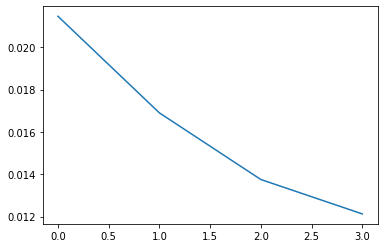

In [22]:
pyplot.plot(simulationResult['f_add'][1])

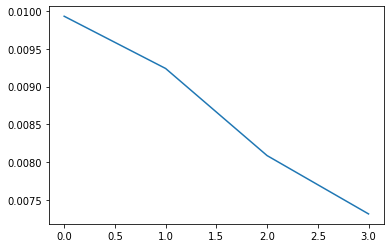

In [23]:
pyplot.plot(simulationResult['f_mul'][1])
save_fig(out_dir, 'f_mul')

In [ ]:
break

In [25]:
SMCF_out = MCVectorVar( name=NameUnit('SMCF', '1'), elements=3)
SMCF_X = McOutputVar(name=NameUnit('SMCFX', '1'))
SMCF_Y = McOutputVar(name=NameUnit('SMCFY', '1'))
SMCF_Z = McOutputVar(name=NameUnit('SMCFZ', '1'))
SMCF_2 = MCVectorVar(name=NameUnit('SMCF_2', '1'), elements=2)

NumberTrials = 300
ch = 1

print(detectors_color[ch, detectorItem].shape)
print(detectors_color[ch, 0].shape)
# Bug in luxpy while spd is only a one spectrum and spd and wl is set separately
detectorMC = list()
for i in range( channels):
    detectorSPD = lx.SPD( spd=np.vstack((detectors_color[i, 0], detectors_color[i, detectorItem])),ax0iswl=True)
    match i:
        case 0: detName = 'DetectorX'
        case 1: detName = 'DetectorY'
        case 2: detName = 'DetectorZ'

    detectorMC.append( McSpectrumVar( name = NameUnit(detName, 'A.U.'), spd= detectorSPD,
        noise_list ={
        #'wl_nc': DistributionParam(mean=0, stddev=1, distribution='uniform'),
        #'wl_c': DistributionParam(mean=0, stddev=10, distribution='uniform'),
        #'wl_f': DistributionParam(mean=0, stddev=1, add_params=4),
        #'v_nc': DistributionParam(mean=0, stddev=0.01),
        #'v_c': DistributionParam(mean=0, stddev=0.01),
        #'v_f': DistributionParam(mean=0, stddev=0.01, add_params=4),
        #'all': None
        }))

spectrumSPD = lx.SPD( spd=np.vstack((_spectra[0], _spectra[SDItem])),ax0iswl=True)
spectrumMC = McSpectrumVar( name = NameUnit('SD', 'A.U.'), spd = spectrumSPD,
    noise_list ={
    #'wl_nc': DistributionParam(mean=0, stddev=1, distribution='uniform'),
    #'wl_c': DistributionParam(mean=0, stddev=10, distribution='uniform'),
    #'wl_f': DistributionParam(mean=0, stddev=1, add_params=4),
    #'v_nc': DistributionParam(mean=0, stddev=0.01),
    #'v_c': DistributionParam(mean=0, stddev=0.01),
    'v_f': DistributionParam(mean=0, stddev=0.01, add_params=4),
    #'all': None
    })


specList = list()
detectorList = list()
for i in range(channels):
    detectorList.append(list())

modelCount = 0

def model_t1(x1):
    global  modelCount
    print('model_t:', modelCount, x1)
    modelCount += 1
    return [x1]

def model_t2(x1, x2):
    global  modelCount
    print('model_t:', modelCount, x1, x2)
    modelCount += 1
    return [x1, x2]

def model_t(x1, x2, x3, x4):
    global  modelCount
    print('model_t:', modelCount, x1, x2, x3, x4)
    modelCount += 1
    return [x1]

def model(spec, detectorX, detectorY, detectorZ):
    # for test only
    global  modelCount
    #print(modelCount)
    modelCount += 1
    specList.append( spec)
    for i in range(channels):
        match i:
            case 0: detectorList[i].append( detectorX)
            case 1: detectorList[i].append( detectorY)
            case 2: detectorList[i].append( detectorZ)

    # implementation
    spectmp = np.vstack( (spec.wl, spec.value) )
    SMCF = np.zeros(3)
    for i in range( channels):
        match i:
            case 0: detectortmp = np.vstack( (detectorX.wl, detectorX.value) )
            case 1: detectortmp = np.vstack( (detectorY.wl, detectorY.value) )
            case 2: detectortmp = np.vstack( (detectorZ.wl, detectorZ.value) )
        SMCF[i] = lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors(
                        spectmp, detectortmp, S_C=calibSD, cieobs='1931_2', s_target_index=i+1)
    # Vektoren gehen noch nicht als Rückgabe
    return [SMCF[0], SMCF[1], SMCF[2], [SMCF[0], SMCF[1]]]

input = [spectrumMC, detectorMC[0], detectorMC[1], detectorMC[2]]
output = [SMCF_X, SMCF_Y, SMCF_Z, SMCF_2]

sim = McSim(trials=NumberTrials)
sim.set_input_var(input)
sim.set_output_var(output)
sim.generate()

#sim.calculate_model(model)
sim.calculate_model(model)

for i in range(len(input)+1):
    print( i)
    for var in sim.output_var[i]:
        var.print_stat()

print(len(specList))
t = np.zeros((len(specList)+1, specList[0].shape[1]))
t[0] = specList[0].wl
t1 = np.zeros((channels, len(detectorList[0])+1, detectorList[0][0].shape[1]))
for ii in range( channels):
    t1[ii][0] = detectorList[0][0].wl
    for i in range(len(specList)):
        t[i+1] = specList[i].value
        t1[ii][i+1] = detectorList[ii][i].value
tmpSPD = SPD(spd=t)

NameError: name 'McOutputVar' is not defined

In [ ]:
plot_2D(sim.output_var[4][3])

In [ ]:
tmpSPD.plot()

In [ ]:
SPD(spd=t1[0]).plot()

In [ ]:
SPD(spd=t1[1]).plot()

In [ ]:
SPD(spd=t1[2]).plot()